In [1]:
# Import Libraries
import os
import numpy as np
from utils import *
import cv2
from random import randint
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
path=os.getenv('HOME') + '/repo/Portrait/data/Celeb/data_100/'

In [3]:
# 이미지와 마스크를 load.
X = np.load(os.path.join(path,"Images.npy"))
Y = np.load(os.path.join(path,"Masks.npy"))
# 마스크를 binary format으로 변경.
Y = np.where(Y > 1, 1, 0)

In [4]:
data_info(X, Y)

이미지의 개수: 300
이미지의 모양: 512 x 512
마스크의 개수: 300
마스크의 모양: 512 x 512


<Figure size 720x720 with 0 Axes>

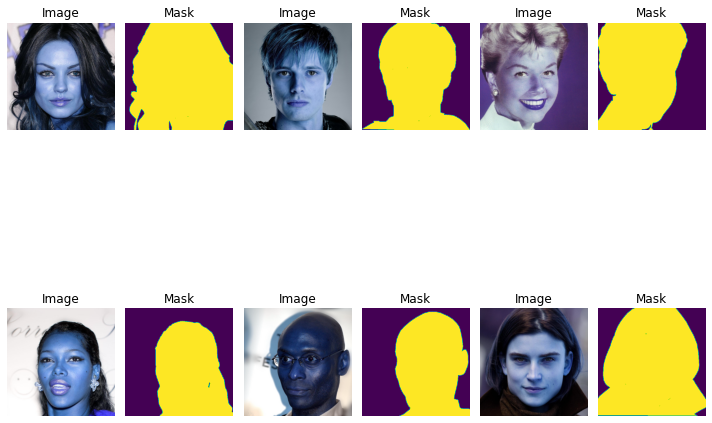

In [5]:
show_image(X, Y, 6)

In [6]:
x_train, y_train, x_valid, y_valid = train_val_split(X,Y)
del X
del Y

In [7]:
# Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator()

In [8]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

## Unet 구현하기

In [9]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, BatchNormalization, Cropping2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import int_shape

In [10]:
def upp_model(input_size=(512,512,3), filters= [0, 32, 64, 128, 256], kernel=3):
    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255) (inputs)
    
    x1_0 = MaxPooling2D(pool_size=(2,2), name='x1_0_pool')(inputs)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv1')(s)
    x1_0 = BatchNormalization()(x1_0)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv2')(x1_0)
    x1_0 = BatchNormalization()(x1_0)
    
    x2_0 = MaxPooling2D(pool_size=(2,2), name='x2_0_pool')(x1_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv1')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv2')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    
    x3_0 = MaxPooling2D(pool_size=(2,2), name='x3_0_pool')(x2_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv1')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv2')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    
    x4_0 = MaxPooling2D(pool_size=(2,2), name='x4_0_pool')(x3_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv1')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv2')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    
    u4_0 = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u4_0_convTran')(x4_0)
    r3_0 = tf.image.resize(x3_0, (u4_0.shape[1], u4_0.shape[2]), name='x3_0_resize')
    x3_1 = concatenate([r3_0, u4_0], axis = 3, name='x3_1_merge')
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv1')(x3_1)
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv2')(x3_1)
    
    # 2-2로 감
    u3_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_0_convTran')(x3_0)
    r2_0 = tf.image.resize(x2_0, (u3_0.shape[1], u3_0.shape[2]), name='a_r2_0_resize')
    x2_1 = concatenate([r2_0,u3_0], axis = 3, name='x2_1_merge')
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv1')(x2_1)
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv2')(x2_1)
    
    # origin
    u3_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_1_convTran')(x3_1)
    r2_0 = tf.image.resize(x2_0, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_0_resize')
    r2_1 = tf.image.resize(x2_1, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_1_resize')
    x2_2 = concatenate([r2_0,r2_1, u3_1], axis = 3, name='x2_2_merge')
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv1')(x2_2)
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv2')(x2_2)
    
    # 1-3로 감
    u2_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_0_convTran')(x2_0)
    r1_0 = tf.image.resize(x1_0, (u2_0.shape[1], u2_0.shape[2]), name='a_r1_0_resize')
    x1_1 = concatenate([r1_0,u2_0], axis = 3, name='x1_1_merge')
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv1')(x1_1)
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv2')(x1_1)
    
    # 1-3로 감
    u2_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_1_convTran')(x2_1)
    r1_0 = tf.image.resize(x1_0, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_1_resize')
    x1_2 = concatenate([r1_0, r1_1, u2_1], axis = 3, name='x1_2_merge')
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv1')(x1_2)
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv2')(x1_2)
    
    # origin
    u2_2 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_2_convTran')(x2_2)
    r1_0 = tf.image.resize(x1_0, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_1_resize')
    r1_2 = tf.image.resize(x1_2, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_2_resize')
    x1_3 = concatenate([r1_0, r1_1, r1_2, u2_2], axis = 3, name='x1_3_merge')
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv1')(x1_3)
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv2')(x1_3)
    x1_3 = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='x1_3_conv3')(x1_3)
    x1_3 = Conv2D(1, 1, activation='sigmoid')(x1_3)
    outputs = tf.image.resize(x1_3, (inputs.shape[1], inputs.shape[2]), name='output')
    
    model = Model(inputs = inputs, outputs = outputs)
    
    model.compile(optimizer='adam', loss='binary_crossentropy')

    model.summary()
    
    return model

In [11]:
batch_size = 4
model = upp_model()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
x1_0_conv1 (Conv2D)             (None, 510, 510, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 510, 510, 32) 128         x1_0_conv1[0][0]                 
_______________________________________________________________________________________

In [12]:
history = model.fit(image_datagen.flow(x_train, y_train, batch_size = batch_size), 
                      steps_per_epoch=x_train.shape[0]/batch_size,
                      validation_data=(x_valid, y_valid), 
                      validation_steps=x_valid.shape[0]/batch_size,
                      epochs=20)

Epoch 1/20
60/60 [==============================] - 27s 453ms/step - loss: 0.4658 - val_loss: 0.7004
Epoch 2/20
60/60 [==============================] - 27s 455ms/step - loss: 0.4018 - val_loss: 0.5315
Epoch 3/20
60/60 [==============================] - 27s 456ms/step - loss: 0.3693 - val_loss: 0.5134
Epoch 4/20
60/60 [==============================] - 28s 464ms/step - loss: 0.3406 - val_loss: 0.7862
Epoch 5/20
60/60 [==============================] - 31s 523ms/step - loss: 0.3340 - val_loss: 0.5488
Epoch 6/20
60/60 [==============================] - 29s 488ms/step - loss: 0.3195 - val_loss: 0.4555
Epoch 7/20
60/60 [==============================] - 29s 481ms/step - loss: 0.2954 - val_loss: 0.3643
Epoch 8/20
60/60 [==============================] - 31s 514ms/step - loss: 0.3092 - val_loss: 0.4354
Epoch 9/20
60/60 [==============================] - 30s 497ms/step - loss: 0.2928 - val_loss: 0.4000
Epoch 10/20
60/60 [==============================] - 28s 474ms/step - loss: 0.2664 - val_lo

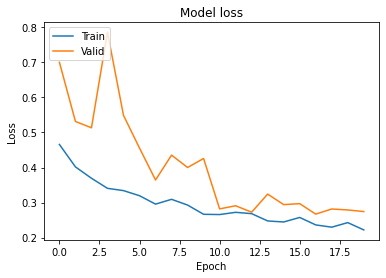

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [ ]:
# Saving the model
model.save('model.h5')

Testing Phase

In [ ]:
# Load the model
model = load_model('model.h5')

# Read the Test Images and their respective masks
x_test = np.load(os.path.join(os.getcwd(),"Test_Images.npy"))
y_test = np.load(os.path.join(os.getcwd(),"Test_Masks.npy"))

# Convert Masks to Binary Masks
y_test = np.where(y_test > 1, 1, 0)

In [ ]:
x_test.shape

In [ ]:
import timeit
start = timeit.default_timer()

output = []
for test_img in x_test:
  output.append(model.predict(test_img.reshape(1,512,512,3))[0,:,:,:])
output = np.array(output)

stop = timeit.default_timer()

# Convert pixel values from float to integer
output = np.where(output > 0.9, 1, 0)
output = output.astype('uint8')

print('Time to inference the model for a single image:', (stop-start)/test_img.shape[0],'s')
print('A 30 FPS real-time engine will require ',1/30,'s inference time for a single Image')

Dilation Operation on the predicted masks to smooth out the masks

In [ ]:
  kernel = np.ones((15,15),np.uint8)
  dilate_opt = []
  for image in output:
    dilate_opt.append(cv2.dilate(image,kernel,iterations = 1))
  dilate_opt = np.array(dilate_opt)
  dilate_opt = np.expand_dims(dilate_opt, axis=-1)

In [ ]:
plt.figure(figsize=(10,10))

for i in list(np.linspace(1,13,4, dtype = int)):
  idx = randint(0,24)
  plt.subplot(6,4,i)
  plt.title('Image')
  plt.axis('off')
  plt.imshow(x_test[idx,:,:,:])

  plt.subplot(6,4,i+1)
  plt.title('Predicted')
  plt.axis('off')
  plt.imshow(output[idx,:,:,0])

  plt.subplot(6,4,i+2)
  plt.title('Dilating Predicted')
  plt.axis('off')
  plt.imshow(dilate_opt[idx,:,:,0])

  plt.subplot(6,4,i+3)
  plt.title('Actual')
  plt.axis('off')
  plt.imshow(y_test[idx,:,:,0])

plt.show()